Define values for Data Points

In [950]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install scikit-learn

In [951]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# Define Sigma Values

In [952]:
sigma_list = np.linspace(0.1, 2, num = 20 ,dtype=float)
sigma_list=np.round(sigma_list,1)
print(sigma_list)
print(sigma_list.shape)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
(20,)


# Initialise performance variables

In [953]:
accuracy_list_1=[]
accuracy_list_2=[]
accuracy_list_3=[]
mse_list_1=[]
mse_list_2=[]
mse_list_3=[]



# Functions to create Dataset

In [954]:
#Here i=0,1,2...20, returns float
def value_func(i):
    return round(-2+0.2*i,2)

# Returns list of values that x1,x2 can take
def value_gen(max_val):
    i_list = np.linspace(0, 20, num = 21,dtype=int)
    print("Range of i and j is : ",i_list) # Gives the range of i,j
    values_list=list(map(value_func,i_list))
    print("List of values",values_list)
    return values_list

#Returns a 441x2 np_array which is the training data. 441 samples with 2 input features each
def random_train_samples(value_list):
    train_data = []
    for num_samples in range(441):
        row = []  
        for num_features in range(2):
            row.append(random.choice(value_list))
        train_data.append(row) 
    train_data=np.array(train_data)
    return train_data

# train_pt is a 1x2 np array, returns int
def squared_sum(train_pt):
    return (train_pt[0]**2)+(train_pt[1]**2)

# Returns a 441x1 np array containing the output labels as per f(x1,x2)
def train_labels(train_data):
    labels=[]       #Output Labels
    square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
    for i in range(train_data.shape[0]):
        square_sum.append(squared_sum(train_data[i]))
        if squared_sum(train_data[i])<=1:
            labels.append(1)
        else:
            labels.append(-1)
    labels=np.array(labels)
    labels=np.reshape(labels,(441,1))
    square_sum=np.array(square_sum)
    square_sum=np.reshape(square_sum,(441,1))
    return labels,square_sum



# Functions to create Centres

In [955]:
#returns rbf centres-441x2 matrix
def rbf_centres_all(train_data):
    return train_data

def rbf_centres_random(train_data):
    rbf_centres =np.empty((150,2))
    for num_samples in range(150):
        rbf_centres[num_samples]=random.choice(train_data)
    return rbf_centres

def rbf_centres_kmeans(train_data,K):
    kmeans = KMeans(n_clusters=K,n_init='auto').fit(train_data)
    centres=kmeans.cluster_centers_
    return centres


# Functions for Interpolation

In [956]:
def gaussian_kernel(ip_array, center_vector, sigma):
    x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
    return x



def rbf(train_data,centres,sigma):
    phi = np.zeros((train_data.shape[0], centres.shape[0]))
    for i in range(train_data.shape[0]):
        for j in range(centres.shape[0]):
            phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
    return phi

def weights(rbf_output,op_labels):
    G_pinv=np.linalg.pinv(rbf_output)
    D=op_labels
    W=np.dot(G_pinv,D)
    return W

def predict(W,G):
#     Y=np.dot(W.T,G)
    Y=np.dot(G,W)
    Y=np.array(Y)
    Y=np.sign(Y)
    return Y


# Functions to evaluate performance

In [957]:
def calculate_accuracy(pred_op,actual_op):
    accuracy = np.mean(pred_op == actual_op) * 100
    return accuracy

def calculate_mse(pred_op,actual_op):
    mse= np.mean((pred_op - actual_op) ** 2)*100
    return mse


# Functions to visualise data

In [958]:

def plot(train_data, labels, ptype):
    inside_circle = train_data[labels.flatten() == 1.0]
    outside_circle = train_data[labels.flatten() == -1.0]
    plot_type = {1: "Train Points", 2: "RBF-All", 3: "RBF-Random", 4: "RBF-KMeans"}


    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot inside circle points
    ax.scatter(inside_circle[:, 0], inside_circle[:, 1], color='orangered', label='Inside Circle')
    
    # Plot outside circle points 
    ax.scatter(outside_circle[:, 0], outside_circle[:, 1], color='mediumblue', label='Outside Circle')
    

    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)
    ax.set_title('Points Inside and Outside Circle - ' + plot_type[ptype], fontsize=14, fontweight='bold')

    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()


In [959]:
def acc_mse_plot(perc_list,sig_list,mse=False):
    
    plt.figure(figsize=(16,10))
    plt.plot(sig_list, perc_list, marker='o', linestyle='-', color='b')
    
    plt.xlabel('Sigma',fontsize=12)
    if mse:
        plt.ylabel('Mean Squared Error in %',fontsize=12)
        plt.title('Sigma v/s MSE Graph',fontsize=12,fontweight='bold')
    else:
        plt.ylabel('Accuracy in %',fontsize=12)
        plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()  

In [960]:
def comp_plot(acc_list_1,acc_list_2,acc_list_3,sig_list):
    
    plt.figure(figsize=(16,10))
    
    plt.plot(sig_list,acc_list_1,marker='o', linestyle='-',color="red",label="All")
    plt.plot(sig_list,acc_list_2,marker='o', linestyle='--',color="blue",label="Random")
    plt.plot(sig_list,acc_list_3,marker='o', linestyle='-.',color="green",label="KMeans")
    
    plt.xlabel('Sigma',fontsize=12)
    plt.ylabel('Accuracy in %',fontsize=12)
    plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.legend(fontsize=10)
    plt.tight_layout()

# RBF Function

In [961]:
def RBF_NN(train_data,op_labels,sigma,quest,K=None):
    
    if quest==1:
        rbf_centres=rbf_centres_all(train_data)
    elif quest==2:
        rbf_centres=rbf_centres_random(train_data)
    elif quest==3:
        rbf_centres=rbf_centres_kmeans(train_data,K)
        
    rbf_output=rbf(train_data,rbf_centres,sigma)
    W=weights(rbf_output,op_labels)
    Y_train=predict(W,rbf_output)
    
    accuracy_train=calculate_accuracy(Y_train,op_labels)
    mse_train=calculate_mse(Y_train,op_labels)
    
    if quest==1:
        accuracy_list_1.append(accuracy_train)
        mse_list_1.append(mse_train)
    elif quest==2:
        accuracy_list_2.append(accuracy_train)
        mse_list_2.append(mse_train)
    elif quest==3:
        accuracy_list_3.append(accuracy_train)
        mse_list_3.append(mse_train)
        
    return Y_train

## Training Data

### List of values allowed

In [962]:
values_list=value_gen(20)

Range of i and j is :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
List of values [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


### Save Training Samples

In [963]:
#Save train_data
train_data=random_train_samples(values_list)
data_df=pd.DataFrame(train_data,columns=['x1','x2'])


### Compute Actual Output Labels

In [964]:
# Save actual output labels and squared sum of x1, x2
op_labels,squared_op=train_labels(train_data)
print("Shape of Output labels is :",op_labels.shape)

data_df['(x1^2) + (x2^2)']=squared_op
data_df['Actual O/P']=op_labels
        

Shape of Output labels is : (441, 1)


### Display Training Data

In [965]:
# Training Data Frame
data_df

,x1,x2,(x1^2) + (x2^2),Actual O/P
0,1.2,-0.8,2.08,-1
1,1.4,-1.0,2.96,-1
2,0.0,-0.8,0.64,1
3,-1.4,0.6,2.32,-1
4,-1.0,-1.0,2.00,-1
...,...,...,...,...
436,1.6,-0.6,2.92,-1
437,0.4,0.0,0.16,1
438,0.0,-0.4,0.16,1
439,-1.6,0.0,2.56,-1


### Training Data Plot

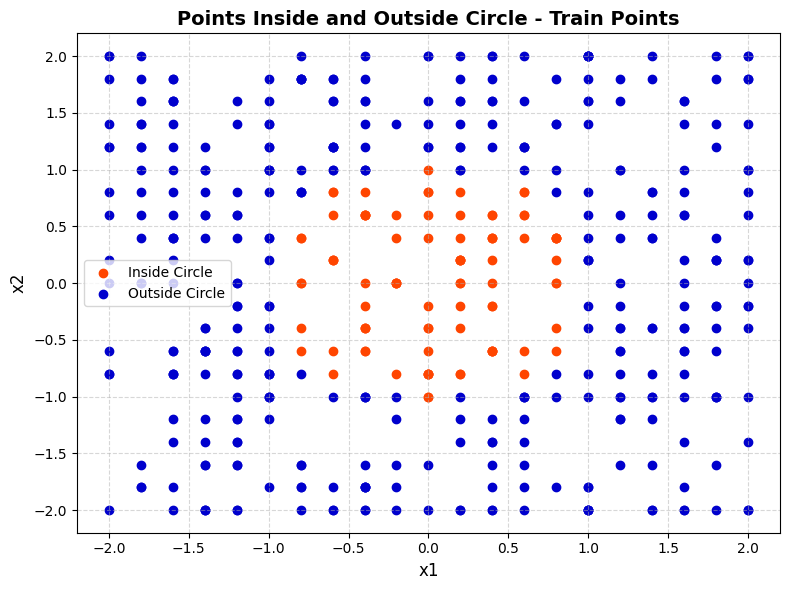

In [966]:
plot(train_data,op_labels,1)

In [967]:
# train_data,op_labels,val_data,val_op_labels=train_test_split(data,op_labels_)

## Question 1

In [968]:
output_1=[]

for sigma in sigma_list:
#     RBF_NN(train_data,op_labels,sigma,1)
    output_1.append(RBF_NN(train_data,op_labels,sigma,1))

In [969]:
accuracy_list_1

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.77324263038548,
 99.77324263038548,
 99.77324263038548,
 99.77324263038548,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646]

In [970]:
len(accuracy_list_1)

20

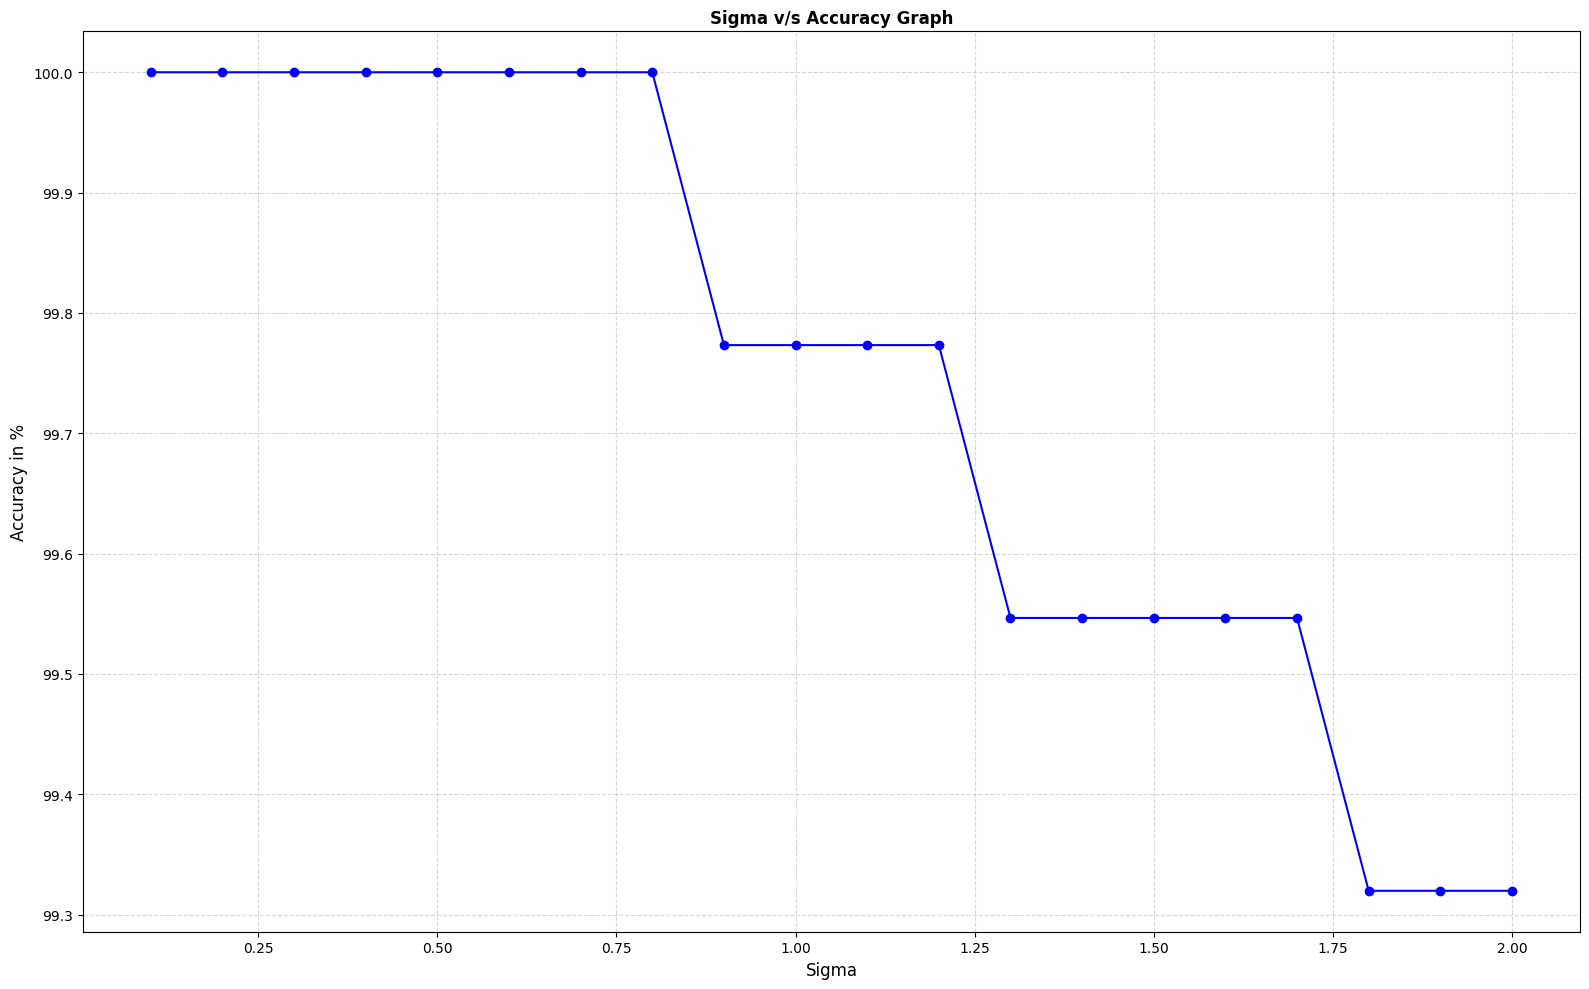

In [971]:
acc_mse_plot(accuracy_list_1,sigma_list)

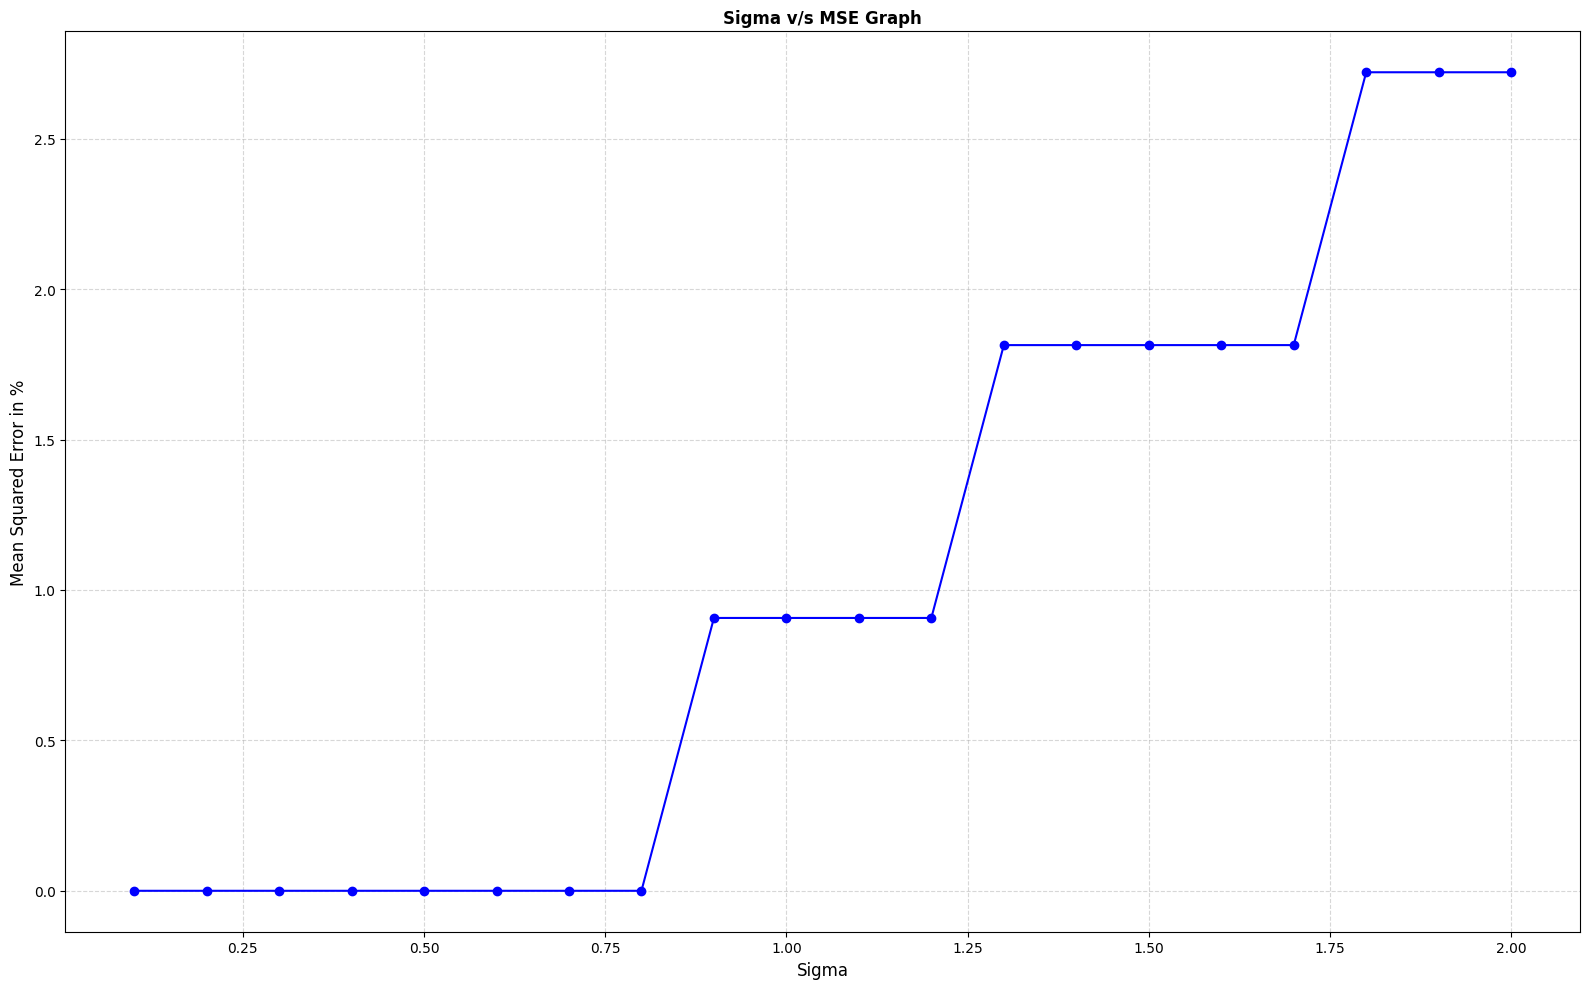

In [972]:
acc_mse_plot(mse_list_1,sigma_list,mse=True)

20
100.0


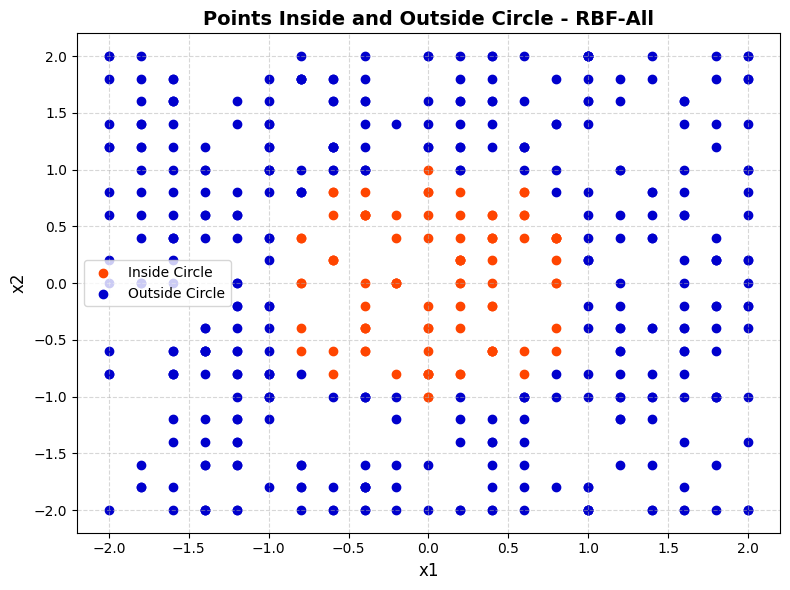

In [973]:
print(len(output_1))
print(max(accuracy_list_1))
# for output in output_1:
plot(train_data,output_1[accuracy_list_1.index(max(accuracy_list_1))],2)


## Question 2


In [974]:
output_2=[]

for sigma in sigma_list:
    output_2.append(RBF_NN(train_data,op_labels,sigma,2))

In [975]:
accuracy_list_2

[97.05215419501134,
 98.63945578231292,
 99.77324263038548,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.31972789115646,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.77324263038548,
 99.09297052154194,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646]

In [976]:
len(accuracy_list_2)

20

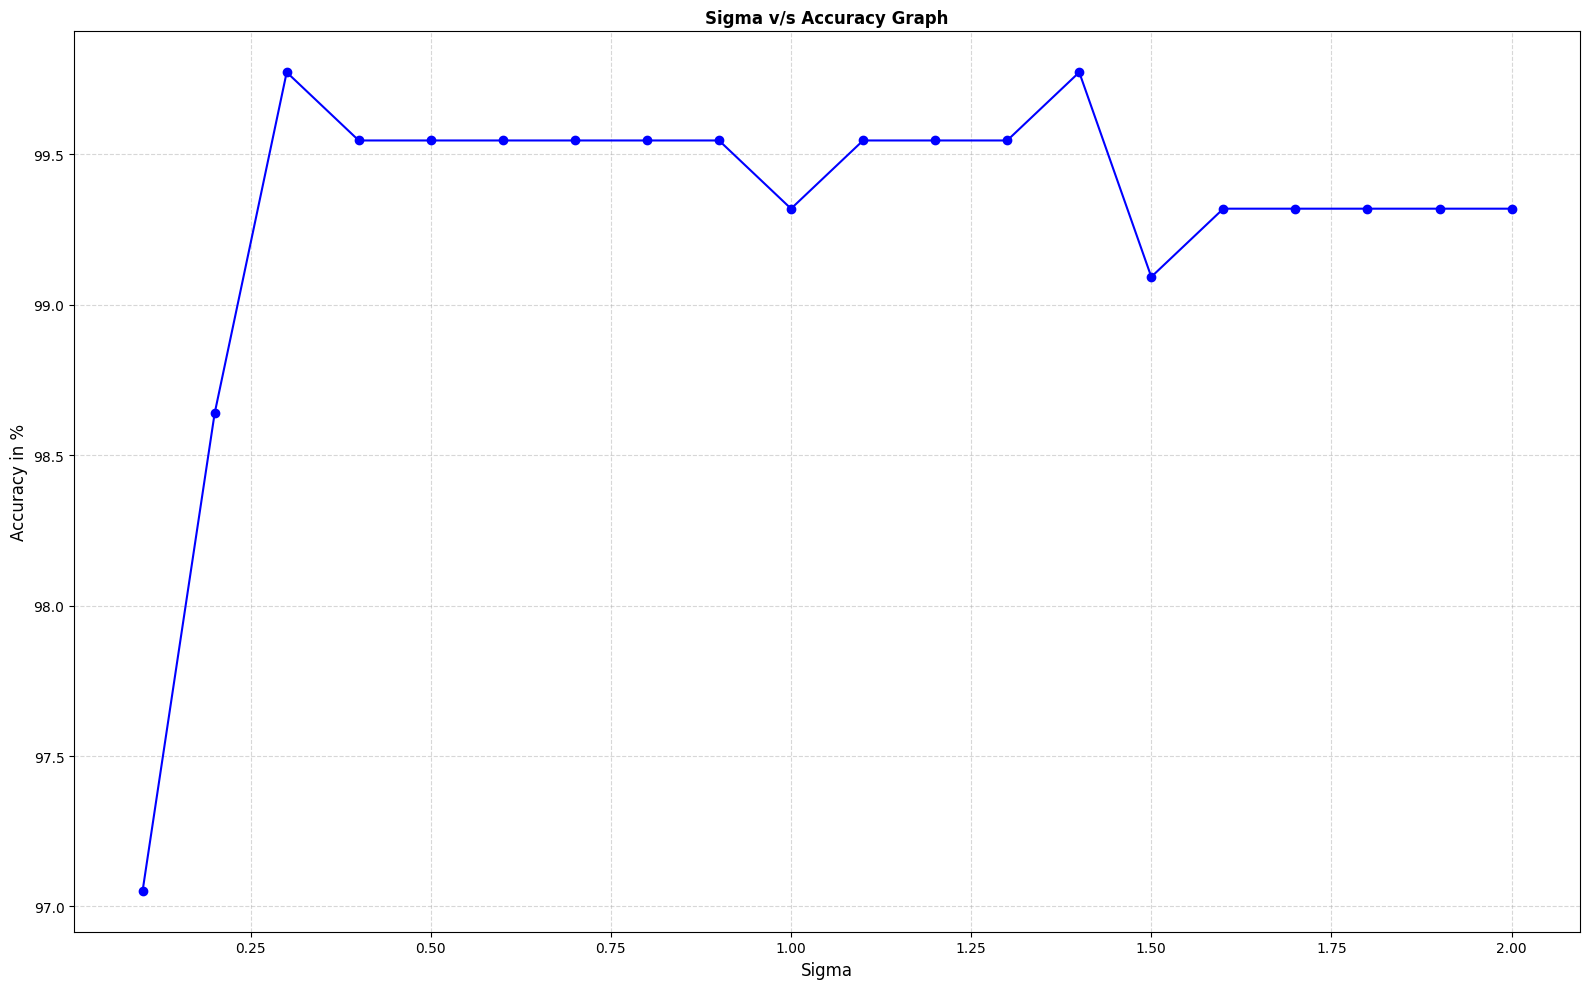

In [977]:
acc_plot(accuracy_list_2,sigma_list)

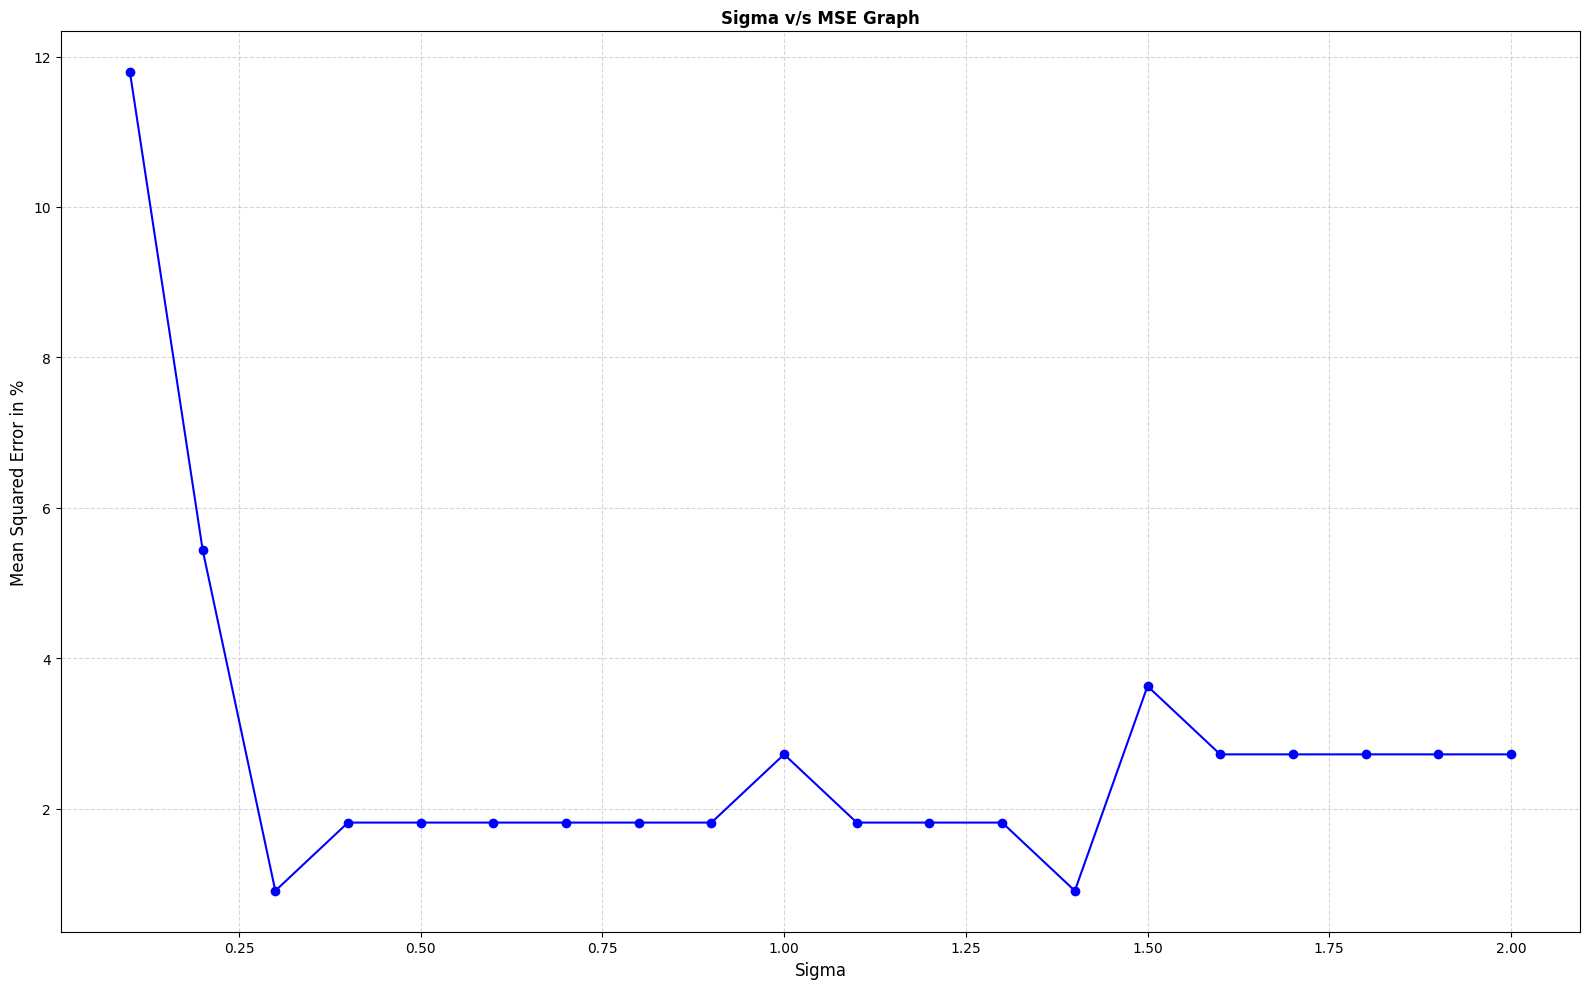

In [978]:
acc_mse_plot(mse_list_2,sigma_list,mse=True)

20
99.77324263038548


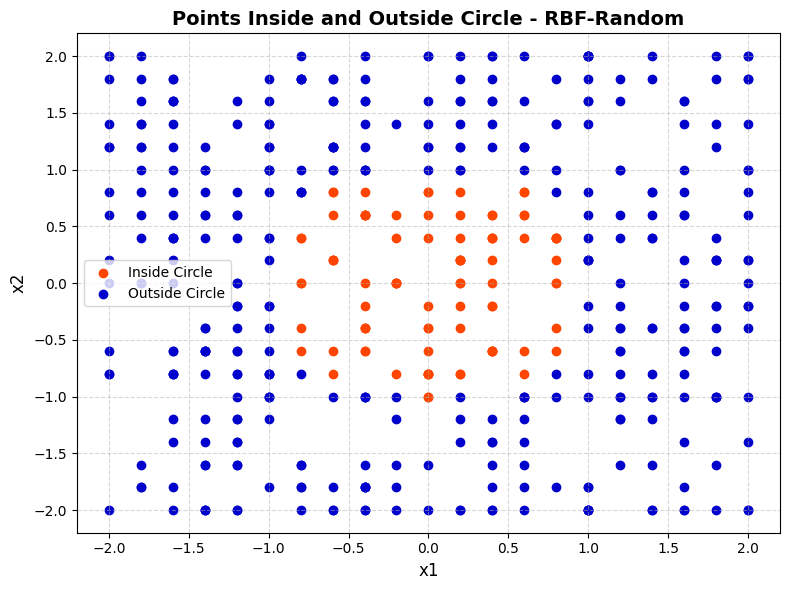

In [979]:
print(len(output_2))
print(max(accuracy_list_2))
# for output in output_1:
plot(train_data,output_2[accuracy_list_2.index(max(accuracy_list_2))],3)

## Question 3

In [980]:
output_3=[]

for sigma in sigma_list:
    output_3.append(RBF_NN(train_data,op_labels,sigma,3,K=120))

In [981]:
accuracy_list_3

[97.95918367346938,
 98.63945578231292,
 99.54648526077098,
 99.77324263038548,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.54648526077098,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646,
 99.31972789115646]

In [982]:
len(accuracy_list_3)

20

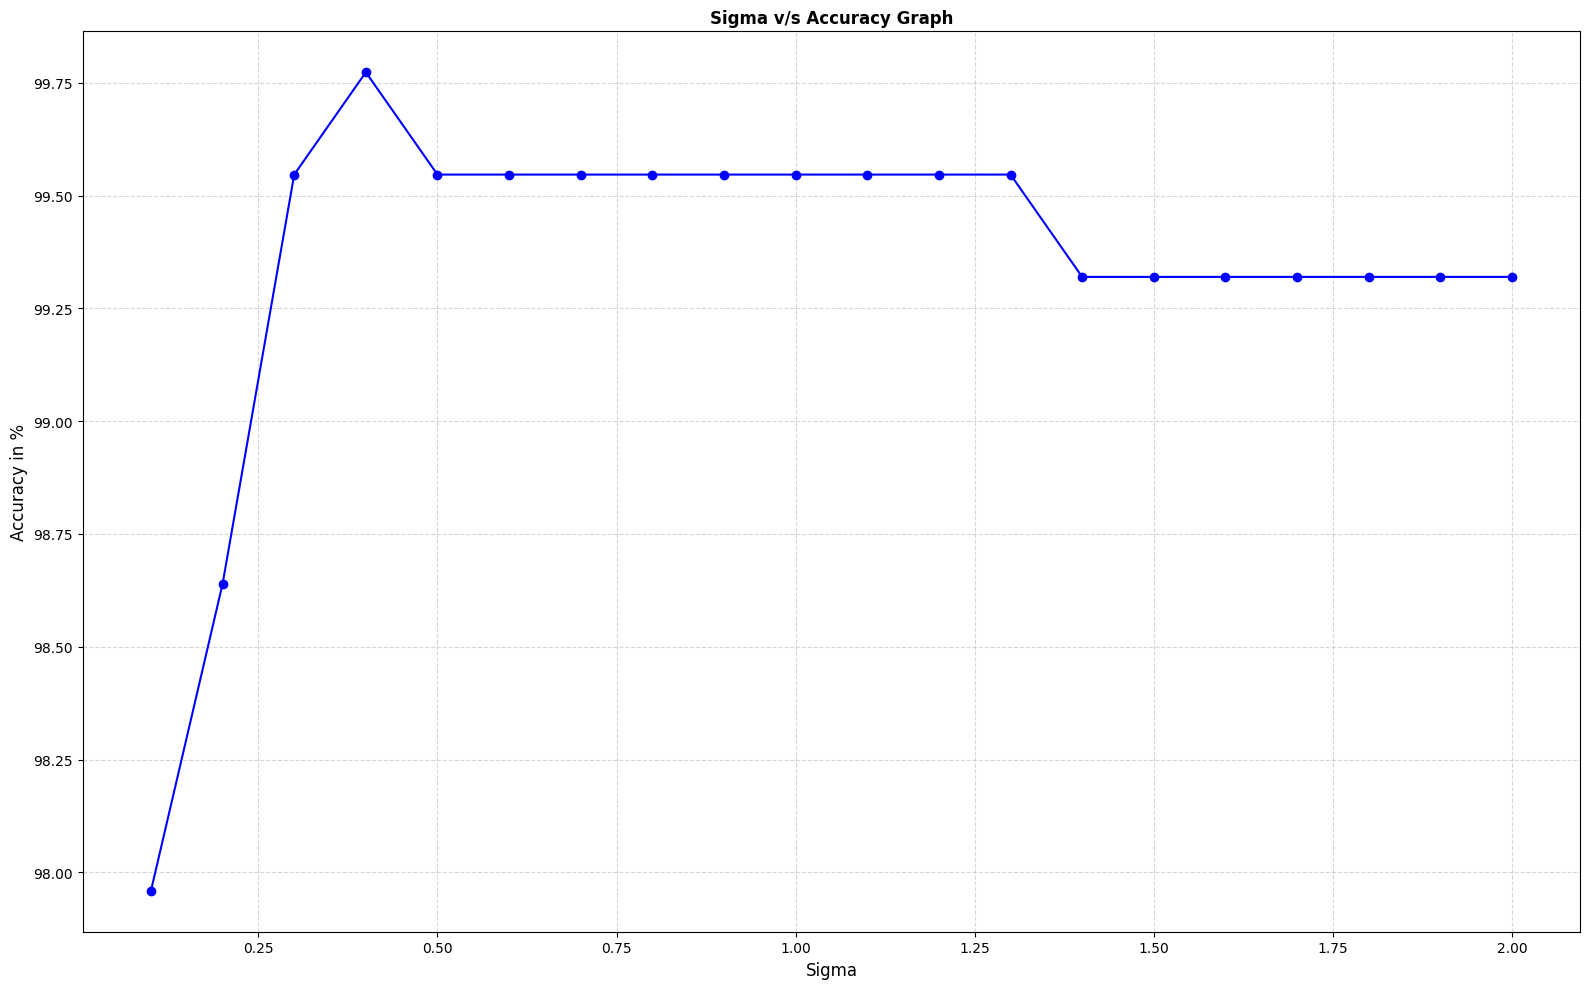

In [983]:
acc_plot(accuracy_list_3,sigma_list)

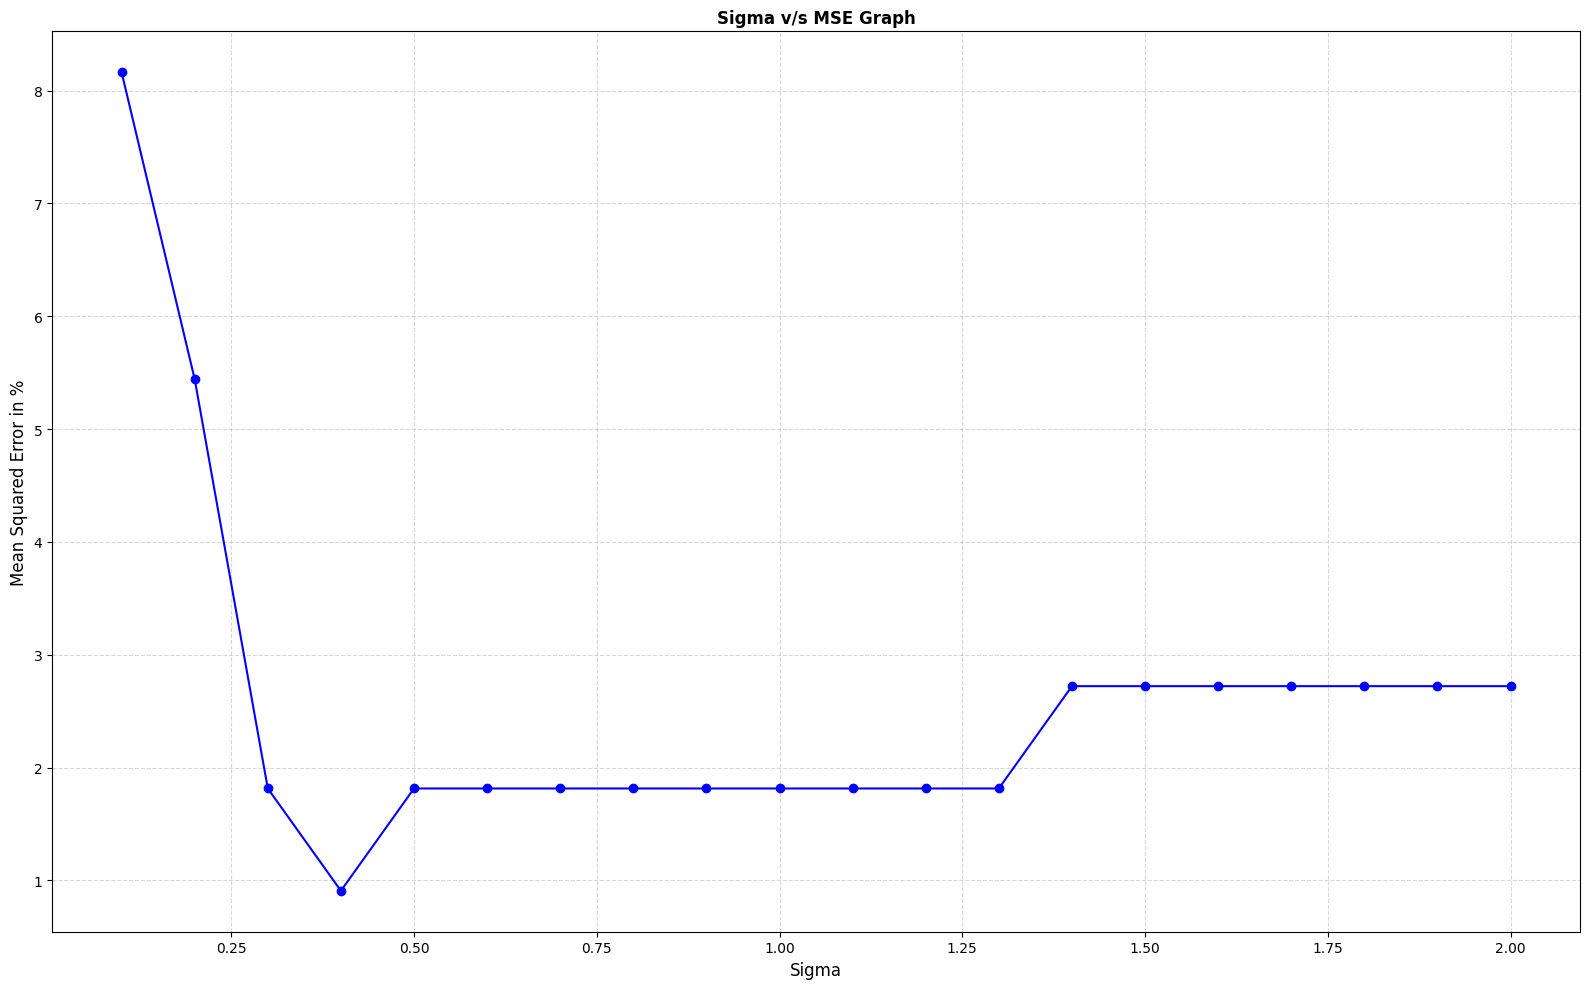

In [984]:
acc_mse_plot(mse_list_3,sigma_list,mse=True)

20
99.77324263038548


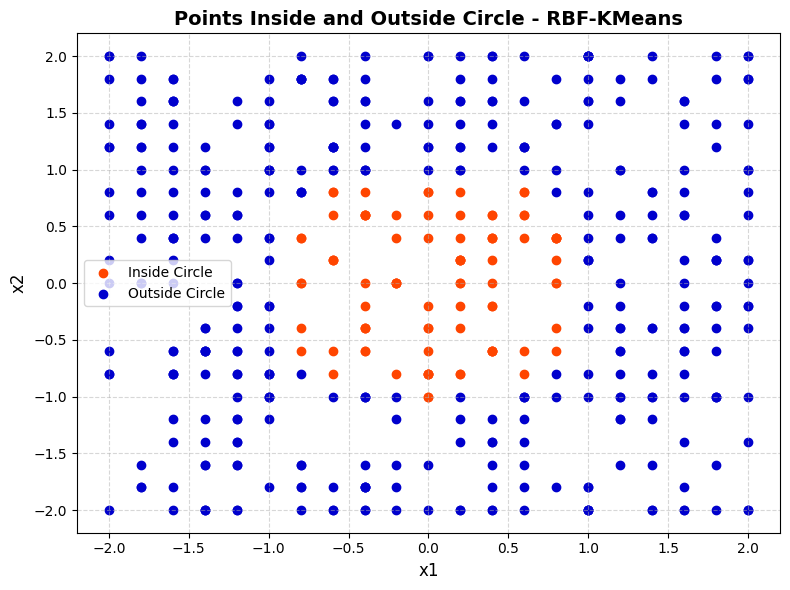

In [985]:
print(len(output_3))
print(max(accuracy_list_3))
# for output in output_1:
plot(train_data,output_3[accuracy_list_3.index(max(accuracy_list_3))],4)

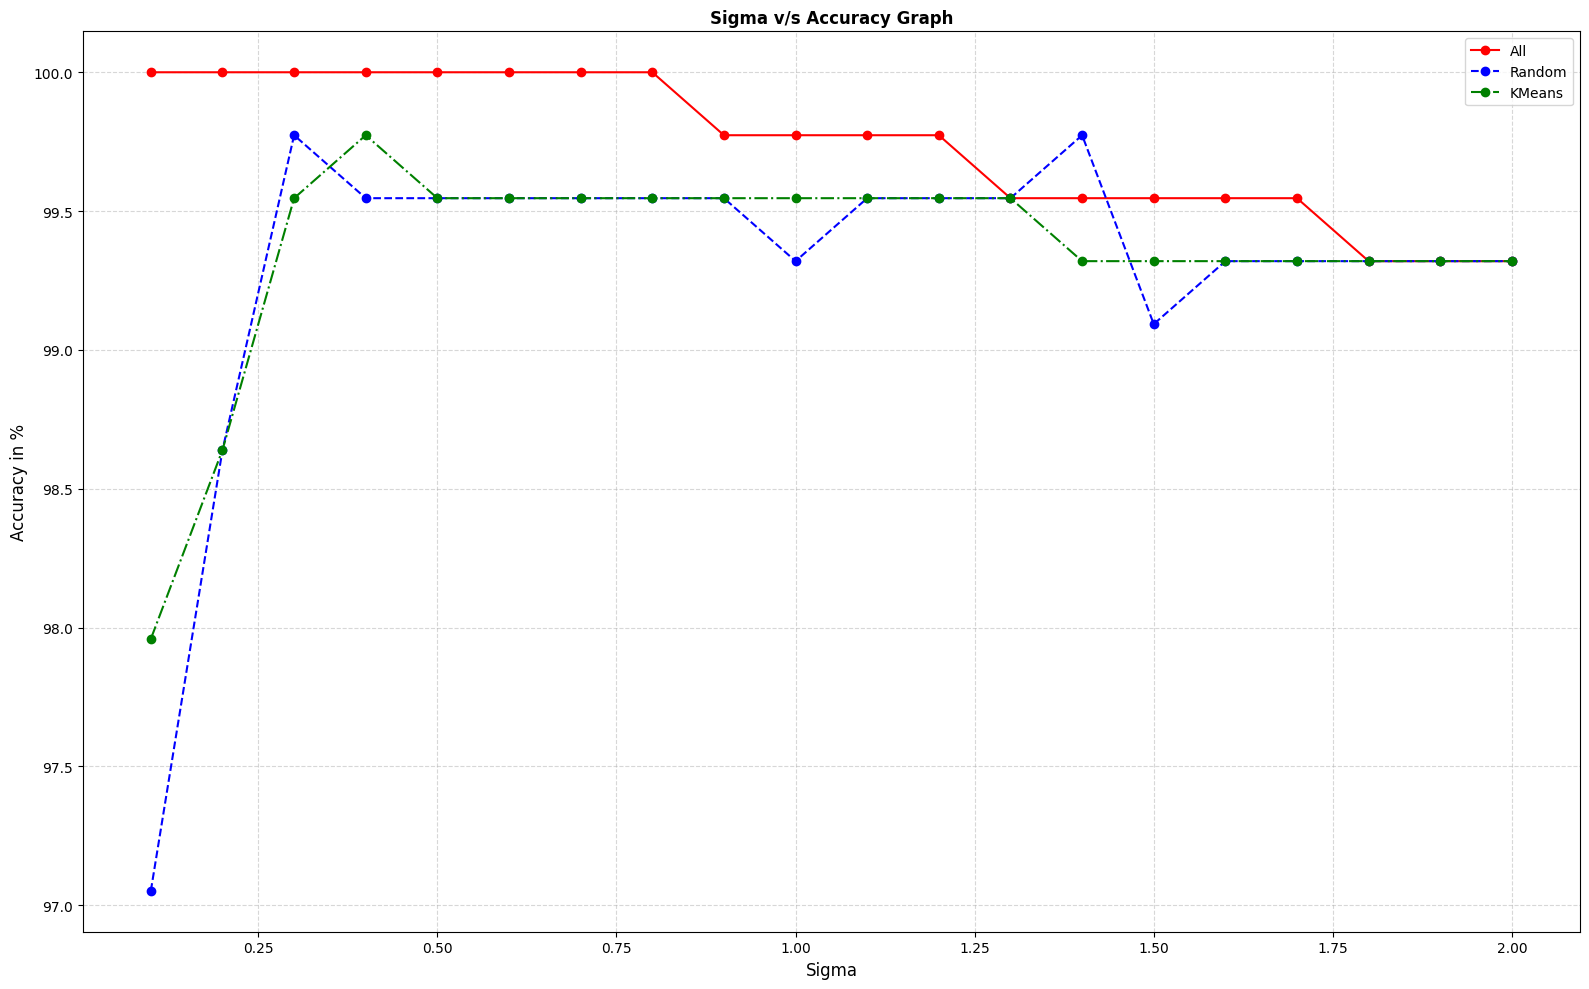

In [986]:
comp_plot(accuracy_list_1,accuracy_list_2,accuracy_list_3,sigma_list)

In [987]:
acc_df={'Sigma':sigma_list,'All':accuracy_list_1,'Random':accuracy_list_2,'KMeans':accuracy_list_3}
pd.DataFrame(acc_df)

,Sigma,All,Random,KMeans
0,0.1,100.000000,97.052154,97.959184
1,0.2,100.000000,98.639456,98.639456
2,0.3,100.000000,99.773243,99.546485
3,0.4,100.000000,99.546485,99.773243
4,0.5,100.000000,99.546485,99.546485
5,0.6,100.000000,99.546485,99.546485
6,0.7,100.000000,99.546485,99.546485
7,0.8,100.000000,99.546485,99.546485
8,0.9,99.773243,99.546485,99.546485
9,1.0,99.773243,99.319728,99.546485
